In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, filtfilt, welch

# Parameters for the double-exponential signal
a = 1e8  # Exponent for rise time
b = 10e6  # Exponent for fall time
sampling_rate = 250e6  # Sampling rate of 1 MHz
duration = 1e-3  # Total duration of the signal in seconds
time = np.arange(0, duration, 1/sampling_rate)

In [41]:
# Poisson parameters
dt = 100e-6  # Time interval in seconds
lambda_poisson = 50  # Average number of signals in interval dt

In [42]:
# Generate double-exponential pulse
def double_exponential(t, a, b):
    return np.exp(-a * t) - np.exp(-b * t)

pulse_length = int(dt * sampling_rate)
pulse_time = np.arange(0, pulse_length/sampling_rate, 1/sampling_rate)
pulse = double_exponential(pulse_time, a, b)

In [43]:
# Generate Poisson-distributed occurrences
num_intervals = int(duration / dt)
interval_length = int(dt * sampling_rate)
signal = np.zeros_like(time)
for i in range(num_intervals):
    if np.random.poisson(lambda_poisson) > 0:
        start_idx = i * interval_length
        end_idx = start_idx + len(pulse)
        if end_idx <= len(signal):
            signal[start_idx:end_idx] = pulse

In [44]:
# Add high-frequency noise
high_freq_noise = np.random.normal(0, 1, time.size) * 5
noisy_signal = signal + high_freq_noise

# Apply Savitzky-Golay filter
window_length = 51  # Must be odd
polyorder = 3
sg_filtered_signal = savgol_filter(noisy_signal, window_length, polyorder)

# Post-processing: Optional further smoothing
window_size = 5
smoothed_signal = np.convolve(sg_filtered_signal, np.ones(window_size)/window_size, mode='valid')

# Adaptive thresholding for triggering
threshold = np.mean(smoothed_signal) + 5 * np.std(smoothed_signal)
trigger_indices = np.where(smoothed_signal > threshold)[0]


In [45]:
# Apply moving average filter
window_size =10  # Size of the moving average window
cumsum = np.cumsum(noisy_signal)
cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
moving_avg = cumsum[window_size - 1:] / window_size

# Pad the moving average to match the length of the original signal
moving_avg = np.pad(moving_avg, (window_size - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))

In [46]:
sg_filtered_signal = savgol_filter(noisy_signal, window_length, 3)

In [47]:
# Post-processing: Optional further smoothing
#window_size = 5
#smoothed_signal = np.convolve(sg_k = 3
# Adaptive thresholding for triggering
k = 3
threshold = np.mean(smoothed_signal) +  k * np.std(smoothed_signal)
trigger_indices = np.where(smoothed_signal > threshold)[0]

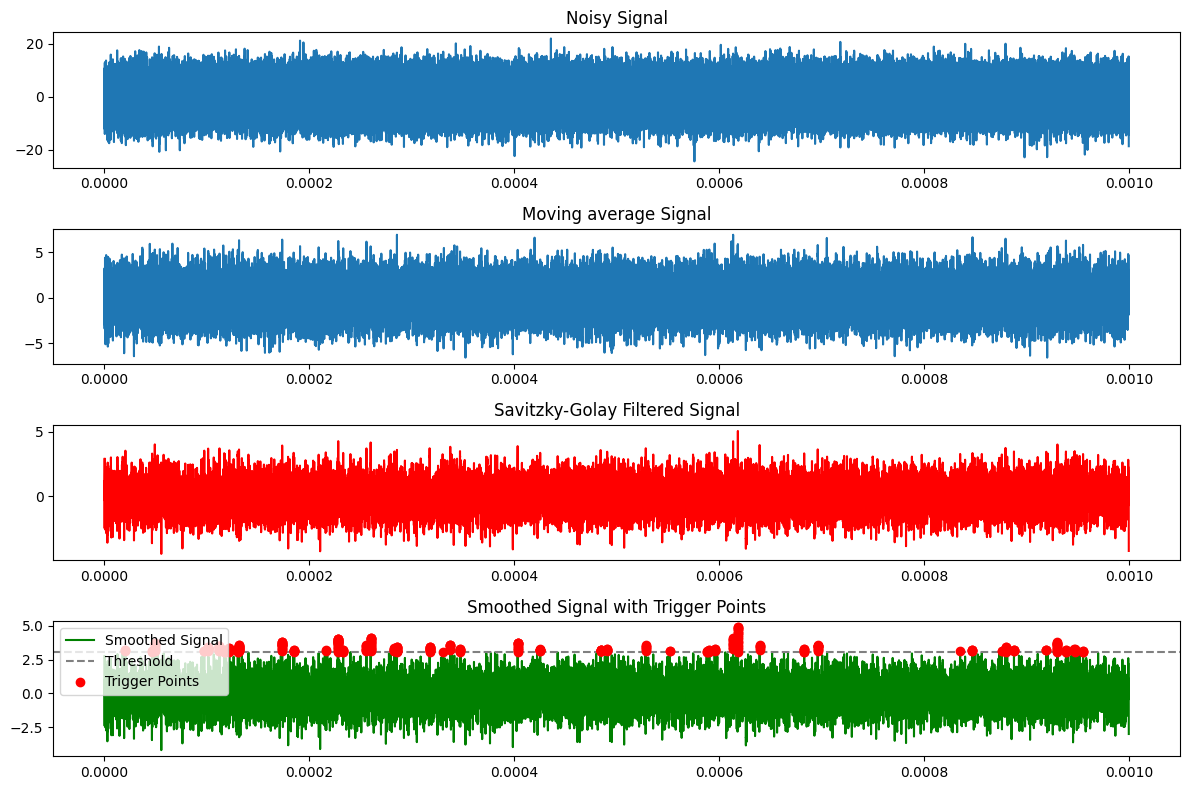

In [50]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time, noisy_signal, label='Noisy Signal')
plt.title('Noisy Signal')

plt.subplot(4, 1, 2)
plt.plot(time, moving_avg, label='Moving avg Signal')
plt.title('Moving average Signal')

plt.subplot(4, 1, 3)
plt.plot(time, sg_filtered_signal, label='Savitzky-Golay Filtered Signal', color='red')
plt.title('Savitzky-Golay Filtered Signal')

plt.subplot(4, 1, 4)
plt.plot(time[:len(smoothed_signal)], smoothed_signal, label='Smoothed Signal', color='green')
plt.axhline(threshold, color='gray', linestyle='--', label='Threshold')
plt.plot(time[trigger_indices], smoothed_signal[trigger_indices], 'ro', label='Trigger Points')
plt.title('Smoothed Signal with Trigger Points')

plt.legend()
plt.tight_layout()
plt.show()

In [51]:
# Compute RMS of noisy signal
rms_noisy_signal = np.sqrt(np.mean(noisy_signal**2))

# Compute RMS of the signal component
rms_signal = np.sqrt(np.mean(signal**2))

# Compute RMS of the noise component
# Noise is the difference between the noisy signal and the filtered signal
noise_component = noisy_signal - sg_filtered_signal
rms_noise = np.sqrt(np.mean(noise_component**2))

# Calculate SNR (Signal-to-Noise Ratio) in linear scale and dB
snr_linear = rms_signal**2 / rms_noise**2
snr_db = 10 * np.log10(snr_linear)
print(f"SNR (linear scale): {snr_linear:.2f}")
print(f"SNR (dB): {snr_db:.2f}")


SNR (linear scale): 0.00
SNR (dB): -48.12


In [52]:
# Compute PSD using Welch's method
frequencies_noisy, psd_noisy = welch(noisy_signal, fs=sampling_rate, nperseg=1024)
frequencies_filtered, psd_filtered = welch(moving_avg, fs=sampling_rate, nperseg=1024)
frequencies_filtered2, psd_filtered2 = welch(sg_filtered_signal, fs=sampling_rate, nperseg=1024)

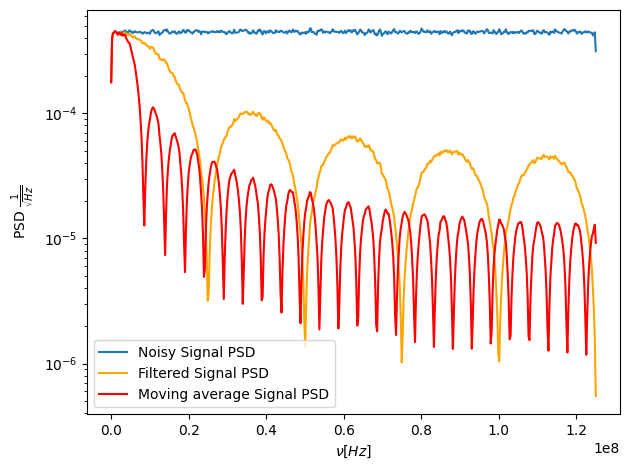

In [53]:
plt.semilogy(frequencies_noisy, np.sqrt(psd_noisy), label='Noisy Signal PSD')
plt.semilogy(frequencies_filtered, np.sqrt(psd_filtered), label='Filtered Signal PSD', color='orange')
plt.semilogy(frequencies_filtered2, np.sqrt(psd_filtered2), label='Moving average Signal PSD', color='red')
plt.xlabel(r'$\nu [Hz]$')
plt.ylabel(r'PSD $\frac{1}{\sqrt{Hz}}$')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
detected_true_signal = sg_filtered_signal > threshold
true_signal = (noisy_signal > 15).astype(int)

In [57]:
# Calculate True Positives, False Positives, True Negatives, False Negatives
TP = np.sum(detected_true_signal & true_signal)
FP = np.sum(detected_true_signal & ~true_signal)
TN = np.sum(~detected_true_signal & ~true_signal)
FN = np.sum(~detected_true_signal & true_signal)

# Calculate metrics
detection_efficiency = TP / (TP + FP) if (TP + FP) > 0 else 0
false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
true_positive_rate = TP / (TP + FN) if (TP + FN) > 0 else 0
false_negative_rate = FN / (TP + FN) if (TP + FN) > 0 else 0

# Print metrics
print(f"Detection Efficiency: {detection_efficiency:.6f}")
print(f"False Positive Rate: {false_positive_rate:.6f}")
print(f"True Positive Rate: {true_positive_rate:.6f}")
print(f"False Negative Rate: {false_negative_rate:.6f}")

Detection Efficiency: 0.019523
False Positive Rate: 0.001810
True Positive Rate: 0.028037
False Negative Rate: 0.971963
